In [1]:
import numpy as np
import math
from numpy import load
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.signal import butter, iirnotch, sosfilt, sosfreqz, lfilter, filtfilt
import biosppy
from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [2]:
plt.rcParams["figure.figsize"] = (10,5)

In [3]:
def butter_highpass(cutoff, sample_rate, order, data):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    final_filtered_highpass = filtfilt(b, a, data)
    return final_filtered_highpass


def butter_lowpass(cutoff, sample_rate, order, data, slice=-1):
    nyq = 0.5 * sample_rate
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    filtered_lowpass = lfilter(b, a, data)
    return filtered_lowpass


def moving_average_filter(x, w):
    m_a_filtered = np.convolve(x, np.ones(w), 'same') / w
    return m_a_filtered


def filter_data(data, sample_rate=100):
    filtered_data_low = butter_lowpass(41.09, sample_rate, 5, data)
    filtered_data_high = butter_highpass(0.48, sample_rate, 2, filtered_data_low)
    #final_filtered_data = moving_average_filter(filtered_data_high, 3)
    return filtered_data_high

In [4]:
def correct_rpeaks(signal, rpeaks=None, sampling_rate=100, tol=0.05):
    """Correct R-peak locations to the maximum within a tolerance.
    Parameters
    ----------
    signal : array
        ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    tol : int, float, optional
        Correction tolerance (seconds).
    Returns
    -------
    rpeaks : array
        Cerrected R-peak location indices.
    Notes
    -----
    * The tolerance is defined as the time interval :math:`[R-tol, R+tol[`.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peaks.")

    tol = int(tol * sampling_rate)
    length = len(signal)

    newR = []
    for r in rpeaks:
        a = r - tol
        if a < 0:
            continue
        b = r + tol
        if b > length:
            break
        newR.append(a + np.argmax(signal[a:b]))

    newR = sorted(list(set(newR)))
    newR = np.array(newR, dtype='int')

    return newR

In [5]:
def _extract_heartbeats(signal=None, rpeaks=None, before=400, after=600):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    before : int, optional
        Number of samples to include before the R peak.
    after : int, optional
        Number of samples to include after the R peak.
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    R = np.sort(rpeaks)
    length = len(signal)
    templates = []
    newR = []

    for r in R:
        a = r - before
        if a < 0:
            continue
        b = r + after
        if b > length:
            break
        templates.append(signal[a:b])
        newR.append(r)

    templates = np.array(templates)
    newR = np.array(newR, dtype='int')

    return templates, newR

In [6]:
def extract_heartbeats(signal=None, rpeaks=None, sampling_rate=1000.,
                       before=0.4, after=0.6):
    """Extract heartbeat templates from an ECG signal, given a list of
    R-peak locations.
    Parameters
    ----------
    signal : array
        Input ECG signal.
    rpeaks : array
        R-peak location indices.
    sampling_rate : int, float, optional
        Sampling frequency (Hz).
    before : float, optional
        Window size to include before the R peak (seconds).
    after : int, optional
        Window size to include after the R peak (seconds).
    Returns
    -------
    templates : array
        Extracted heartbeat templates.
    rpeaks : array
        Corresponding R-peak location indices of the extracted heartbeat
        templates.
    """

    # check inputs
    if signal is None:
        raise TypeError("Please specify an input signal.")

    if rpeaks is None:
        raise TypeError("Please specify the input R-peak locations.")

    if before < 0:
        raise ValueError("Please specify a non-negative 'before' value.")
    if after < 0:
        raise ValueError("Please specify a non-negative 'after' value.")

    # convert delimiters to samples
    before = int(before * sampling_rate)
    after = int(after * sampling_rate)

    # get heartbeats
    templates, newR = _extract_heartbeats(signal=signal,
                                          rpeaks=rpeaks,
                                          before=before,
                                          after=after)

    return templates, newR

In [7]:
def get_complete_Heartbit(sample, sampling_rate=100,plot=True):
    filtered_sample = filter_data(sample,sampling_rate)
    data = filtered_sample.T
    signals = []
    indices = []
    count = 1
    peaks = biosppy.signals.ecg.christov_segmenter(
        signal=data, sampling_rate=sampling_rate)[0]
    rpeaks = correct_rpeaks(signal=data,rpeaks=peaks, sampling_rate=100,tol=0.05)
    print(rpeaks)
    templates, rpeaks = extract_heartbeats(signal=data,rpeaks=rpeaks,sampling_rate=100,before=0.4,after=0.6)
    if plot:
        ts_tmpl = np.linspace(-0.4, 0.6, templates.shape[1], endpoint=False)
        fig = plt.figure()
        gs = gridspec.GridSpec(6, 2)
        ax4 = fig.add_subplot(gs[1:5, 1])
        plt.plot(ts_tmpl, templates.T, 'm', linewidth=1.5, alpha=0.7)
        ax4.set_xlabel('Time (s)')
        ax4.set_ylabel('Amplitude')
        ax4.set_title('Templates')
        ax4.grid()
    #return templates, rpeaks
    return templates

In [8]:
def get_heart_beat(data):
    templates = []
    templates_aux = []
    for i in range(len(data)-1): 
        templates_aux = get_complete_Heartbit(data[i], 100,False)
        k = len(templates);
        for j in range(len(templates_aux)-1):
            templates.append(templates_aux[j])
    return np.array(templates)

### FINAL FUNCTION

In [9]:
def maior_valor_sinal(sinal):
    maior_valor = 0
    for i in range(len(sinal)):
        if(sinal[i] > maior_valor):
            maior_valor = sinal[i]
    return maior_valor

In [10]:
def R_peak_detection(sinal):
    sinal = filter_data(sinal,100)
    indice_aux = 0
    indice_maximo = []
    valor_aux = 0
    valor_maximo = []
    flag_contagem = 0
    indice_temp = 0
    valor_temp = 0
    i = 0
    valor_referencia = maior_valor_sinal(sinal)*0.5
    #print(valor_referencia)
    while i < len(sinal):
        if(sinal[i] > (valor_referencia)):
            indice_aux = i;
            valor_aux = sinal[i];
            for x in range(5):
                if(sinal[indice_aux+x] > valor_aux):
                    indice_temp = indice_aux + x
                    valor_temp = sinal[indice_aux + x]
                    valor_aux = sinal[indice_aux+x]
                else:
                    flag_contagem = flag_contagem + 1
            indice_maximo.append(indice_temp) 
            valor_maximo.append(valor_temp) 
            if(flag_contagem == 5):
                indice_maximo.append(i) 
                valor_maximo.append(sinal[i]) 
            flag_contagem = 0
            indice_temp = 0
            valor_temp = 0
            indice_aux = 0
            valor_aux = 0
            #print(indice_temp+i)
            #print(indice_maximo)
            i = i + 10
        i = i + 1
    contador_zeros = 0
    for j in range (len(indice_maximo)):
        if(indice_maximo[j] == 0):
            contador_zeros = contador_zeros + 1
    for k in range (len(indice_maximo) - contador_zeros):
        if(indice_maximo[k] == 0):
            indice_maximo = np.delete(indice_maximo, k)
    return indice_maximo

### Testing the final function

### Data collected on the SimMan simulator (SR - no noise):

In [16]:
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]

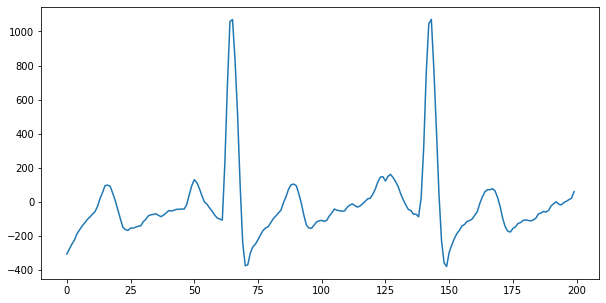

In [17]:
plt.plot(X[0:200])

#### Result using ready-made python library:

In [18]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[ 65 143 218 293 367 440 515 589 662 736 809 883 957]


#### Result using the function created to find the R peaks:

In [21]:
R_peak_detection(X)

[65, 143, 218, 293, 367, 440, 515, 589, 662, 736, 809, 883, 957]

### Data collected on the SimMan simulator (SR - with noise):

In [412]:
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]

#### Result using ready-made python library:

In [413]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[ 56 130 204 278 353 428 502 576 651 725 802 878 954]


#### Result using the function created to find the R peaks:

In [414]:
R_peak_detection(X)

598.6108292843077


[56, 130, 204, 278, 353, 428, 502, 576, 651, 725, 802, 878, 954]

### Data collected on the SimMan simulator (AFIB - no noise):

In [155]:
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]

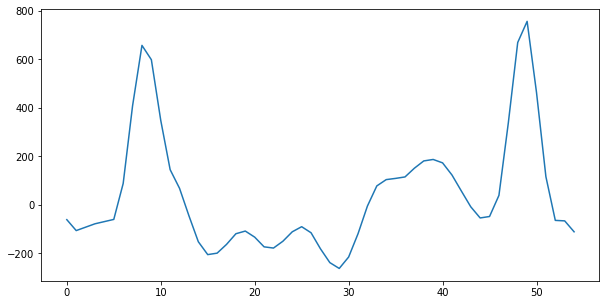

In [165]:
plt.plot(X[130:185])

#### Result using ready-made python library:

In [416]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[ 27  98 179 219 279 349 388 449 494 566 638 708 749 823 896 969]


#### Result using the function created to find the R peaks:

In [417]:
R_peak_detection(X)

426.669458117686


[27,
 98,
 139,
 179,
 219,
 279,
 349,
 388,
 449,
 494,
 566,
 638,
 708,
 749,
 823,
 896,
 969]

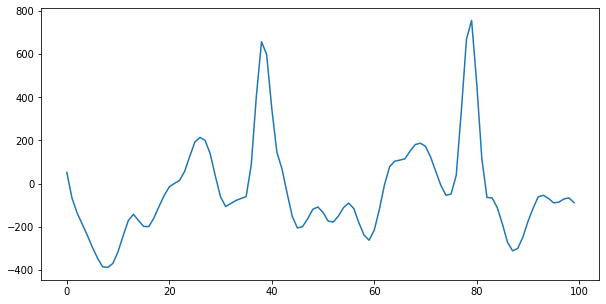

In [418]:
plt.plot(X[100:200])

### Data collected on the SimMan simulator (AFIB - with noise):

In [405]:
df = pd.read_csv("ecg_data_boneco_afib_com_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]

#### Result using ready-made python library:

In [390]:
X_sr = get_complete_Heartbit(X, sampling_rate=100, plot=False)

[ 72 111 152 221 261 328 445 516 582 624 733 783 862 980]


#### Result using the function created to find the R peaks:

In [407]:
R_peak_detection(X)

510.58991867103674


array([  3,  72, 111, 152, 221, 261, 328, 373, 445, 516, 582, 624, 665,
       733, 783, 862, 911, 980])

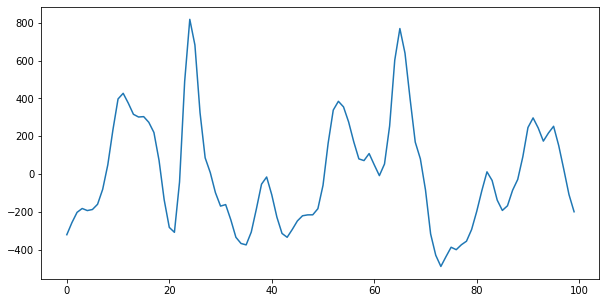

In [409]:
plt.plot(X[600:700])

### Get the heartbeats

In [154]:
def Get_Heartbeats(sinal, picos_R, frequencia_amostragem, plot = True):
    heartbeats = []
    indice_min = 0
    indice_max = 0
    tamanho_sinal = len(sinal)
    for i in range(len(picos_R)):
        indice_min = picos_R[i] - (0.4*frequencia_amostragem)
        indice_max = picos_R[i] + (0.6*frequencia_amostragem)
        if((indice_min > 0) & (indice_max < tamanho_sinal)):
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
    heartbeats = np.array(heartbeats)
    print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

### Testing the function that gets the heartbeats:

### Data collected on the SimMan simulator (SR - no noise):

555.038987990655


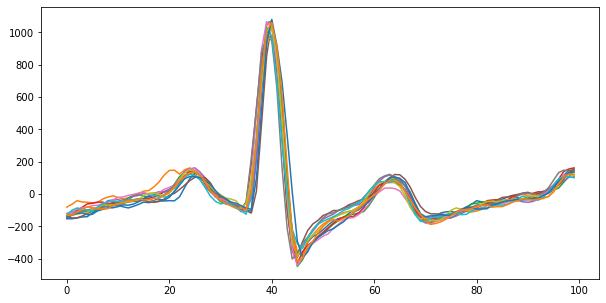

In [79]:
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]
picos_R = R_peak_detection(X)
hb = Get_Heartbeats(X, picos_R, 100)

### Data collected on the SimMan simulator (SR - with noise):

598.6108292843077


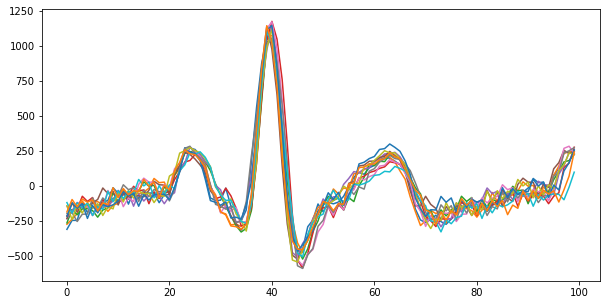

In [80]:
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]
picos_R = R_peak_detection(X)
hb = Get_Heartbeats(X, picos_R, 100)

### Data collected on the SimMan simulator (AFIB - no noise):

426.669458117686


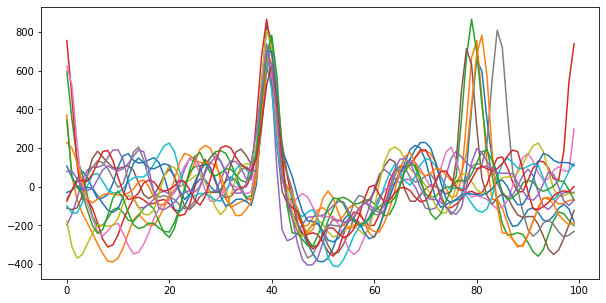

In [82]:
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]
picos_R = R_peak_detection(X)
hb = Get_Heartbeats(X, picos_R, 100)

### Data collected on the SimMan simulator (AFIB - with noise):

510.58991867103674


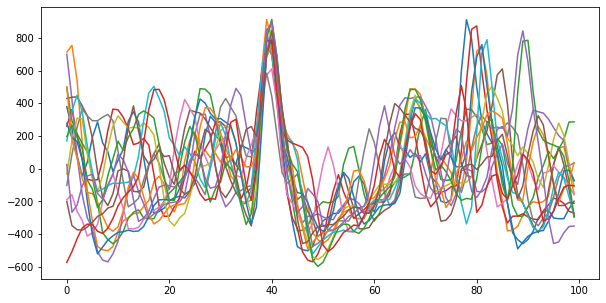

In [85]:
df = pd.read_csv("ecg_data_boneco_afib_com_ruido.csv")
X = df['values'].values.astype('float32')
X = X[:1000]
picos_R = R_peak_detection(X)
hb = Get_Heartbeats(X, picos_R, 100)

### Testing the model with the new heartbeats

In [86]:
import tensorflow as tf
from tensorflow.keras import Sequential,utils
from tensorflow.keras.layers import Input, Flatten, Dense, Conv1D, MaxPooling1D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.models import load_model

from sklearn.utils import resample
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

In [87]:
model_cnn_v10_ecg = load_model('../models/cnn_1d_v10_ecg')
model = model_cnn_v10_ecg

In [88]:
def normalize_data(Xt):
    Xt_full = []
    for i in range(len(Xt)):
        norm = ((Xt[i] - Xt[i].min())/(Xt[i].max() - Xt[i].min()))
        Xt_full.append(norm)

    Xt_full = np.array(Xt_full)
    print(Xt_full.shape)
    return Xt_full

### Data collected on humans:

410.830185545618
(162, 100)


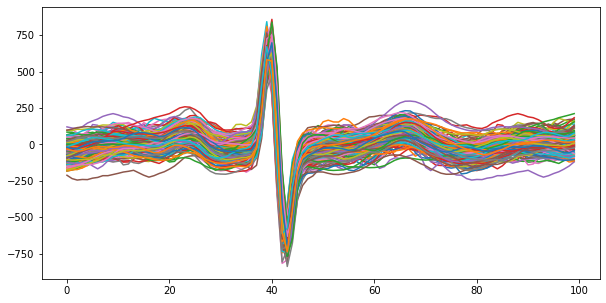

In [176]:
df = pd.read_csv("ecg_homecare_data_10_s_100Hz_ADS1115.csv")
X = df['samples'].values.astype('float32')
picos_R = R_peak_detection(X)
X_sr = Get_Heartbeats(X, picos_R, 100)

In [177]:
X_sr.min(), X_sr.max()
X_sr = normalize_data(X_sr)
print (X_sr.min(), X_sr.max())

(162, 100)
0.0 1.0


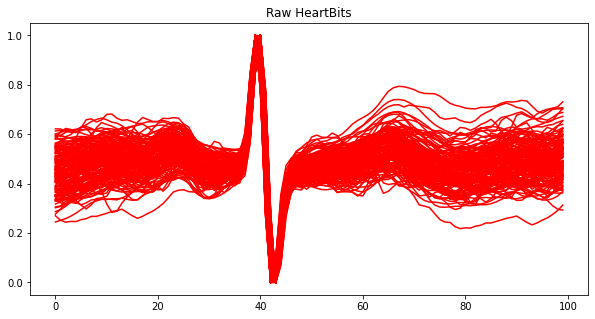

In [178]:
for i in range(len(X_sr)):
    plt.plot(X_sr[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [179]:
pred = []
for i in range (len(X_sr)):
    ecg_pred = model.predict(X_sr[i].reshape(1,100,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  50


### Data collected on the SimMan simulator (SR - no noise):

555.0389879106285
(39, 100)


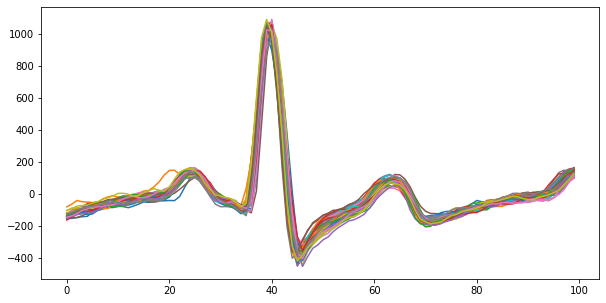

In [158]:
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
X_sr = Get_Heartbeats(X, picos_R, 100)

In [159]:
X_sr.min(), X_sr.max()
X_sr = normalize_data(X_sr)
print (X_sr.min(), X_sr.max())

(39, 100)
0.0 1.0


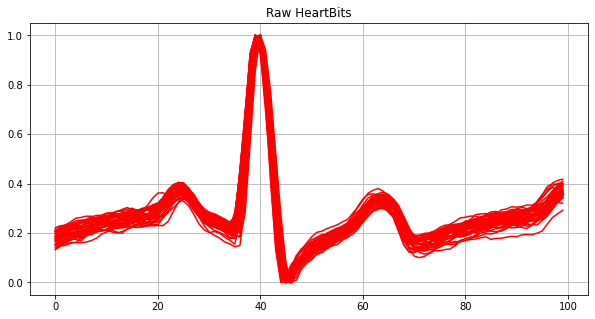

In [160]:
for i in range(len(X_sr)):
    plt.plot(X_sr[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [161]:
pred = []
for i in range (len(X_sr)):
    ecg_pred = model.predict(X_sr[i].reshape(1,100,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  0


### Data collected on the SimMan simulator (SR - with noise):

In [162]:
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
X_sr = Get_Heartbeats(X, picos_R, 100, False)

613.7869571125008
(51, 100)


In [163]:
X_sr.min(), X_sr.max()
X_sr = normalize_data(X_sr)
print (X_sr.min(), X_sr.max())

(51, 100)
0.0 1.0


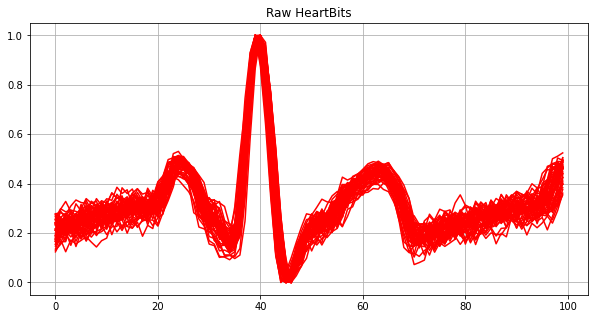

In [164]:
for i in range(len(X_sr)):
    plt.plot(X_sr[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [165]:
pred = []
for i in range (len(X_sr)):
    ecg_pred = model.predict(X_sr[i].reshape(1,100,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  0


### Data collected on the SimMan simulator (AFIB - no noise):

In [167]:
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
X_afib = Get_Heartbeats(X, picos_R, 100, False)

489.5780809750455
(150, 100)


In [168]:
X_afib.min(), X_afib.max()
X_afib = normalize_data(X_afib)
print (X_afib.min(), X_afib.max())

(150, 100)
0.0 1.0


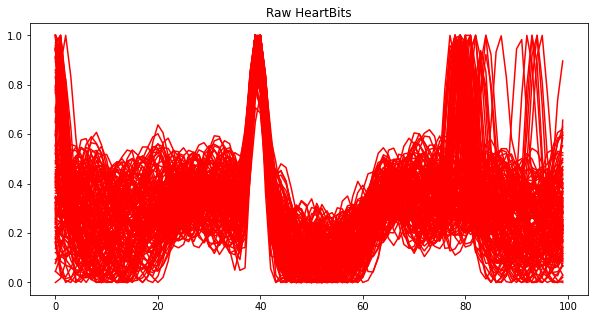

In [169]:
for i in range(len(X_afib)):
    plt.plot(X_afib[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [170]:
pred = []
for i in range (len(X_afib)):
    ecg_pred = model.predict(X_afib[i].reshape(1,100,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  148


### Data collected on the SimMan simulator (AFIB - with noise):

In [172]:
df = pd.read_csv("ecg_data_boneco_afib_com_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
X_afib = Get_Heartbeats(X, picos_R, 100, False)

619.3084990032617
(147, 100)


In [173]:
X_afib.min(), X_afib.max()
X_afib = normalize_data(X_afib)
print (X_afib.min(), X_afib.max())

(147, 100)
0.0 1.0


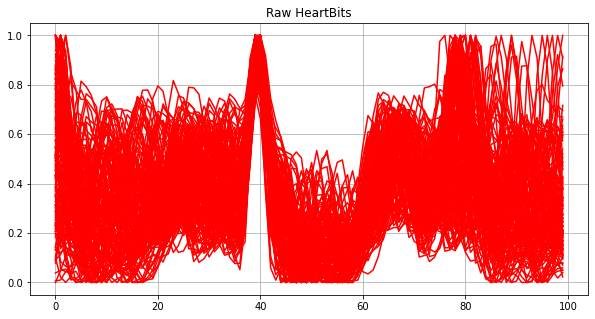

In [174]:
for i in range(len(X_afib)):
    plt.plot(X_afib[i], color = 'r')
    plt.title("Raw HeartBits")
    plt.grid()

In [175]:
pred = []
for i in range (len(X_afib)):
    ecg_pred = model.predict(X_afib[i].reshape(1,100,1))
    ecg_pred = ecg_pred > 0.5
    ecg_pred = ecg_pred[0][0]
    pred.append(ecg_pred)

print ("Number of heartbeats classified as AFIB: ",np.asarray(pred).sum())

Number of heartbeats classified as AFIB:  144


### Calculating the BPM:

In [3]:
def BPM_Calculation(r_peaks):
    bpm_aux = []
    bpm_soma = 0
    bpm = 0
    for i in range(len(r_peaks), 1):
        bpm_aux.append((60*100)/(r_peaks(i)-r_peaks(i-1)))
    for j in range(len(bpm_aux)):
        bpm_soma = bpm_soma + bpm_aux
    bpm = bpm_soma/len(bpm_aux)
    return bpm

### Alternative for creating heartbeats:

In [ ]:
def Get_Heartbeats(sinal, picos_R, frequencia_amostragem, plot = True):
    heartbeats = []
    indice_min = 0
    indice_max = 0
    tamanho_sinal = len(sinal)
    
    for i in range(len(picos_R)):
        indice_min = picos_R[i] - (0.4*frequencia_amostragem)
        indice_max = picos_R[i] + (0.6*frequencia_amostragem)
        if((indice_min > 0) & (indice_max < tamanho_sinal)):
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
    heartbeats = np.array(heartbeats)
    print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [170]:
def Get_Heartbeats_2(sinal, picos_R, frequencia_amostragem, plot = True):
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 20) and (difference_peaks_after >= 40)):
            indice_min = picos_R[i] - (0.2*frequencia_amostragem)
            indice_max = picos_R[i] + (0.4*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 20 and (difference_peaks_after < 40)):
            zero_points_after = 40 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.2*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 20) and (difference_peaks_after >= 40)):
            zero_points_before = 20 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.4*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 20) and (difference_peaks_after < 40)):
            zero_points_before = 20 - int(difference_peaks_before/2)
            zero_points_after = 40 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [203]:
def Get_Heartbeats_3(sinal, picos_R, frequencia_amostragem, plot = True):
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 30) and (difference_peaks_after >= 30)):
            indice_min = picos_R[i] - (0.3*frequencia_amostragem)
            indice_max = picos_R[i] + (0.3*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 30 and (difference_peaks_after < 30)):
            zero_points_after = 30 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.3*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 30) and (difference_peaks_after >= 30)):
            zero_points_before = 30 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.3*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 30) and (difference_peaks_after < 30)):
            zero_points_before = 30 - int(difference_peaks_before/2)
            zero_points_after = 30 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

In [239]:
def Get_Heartbeats_3(sinal, picos_R, frequencia_amostragem, plot = True):
    heartbeats = []
    indice_min = 0
    indice_max = 0
    zero_points_after = 0
    zero_points_before = 0
    zero_points_aux = 0
    zero_points_aux_1 = 0
    zero_points_aux_2 = 0
    hb = []
    tamanho_sinal = len(sinal)
    tamanho_picos = len(picos_R)-1
    for i in range(1,tamanho_picos):
        difference_peaks_before = picos_R[i]-picos_R[i-1]
        difference_peaks_after = picos_R[i+1]-picos_R[i]
        if((difference_peaks_before >= 25) and (difference_peaks_after >= 35)):
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem)
            heartbeats.append(sinal[int(indice_min):int(indice_max)])
        elif((difference_peaks_before) >= 25 and (difference_peaks_after < 35)):
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux = np.zeros(zero_points_after)
            indice_min = picos_R[i] - (0.25*frequencia_amostragem)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((sinal[int(indice_min):int(indice_max)],zero_points_aux), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after >= 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_aux = np.zeros(zero_points_before)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + (0.35*frequencia_amostragem) 
            heartbeats.append(np.concatenate((zero_points_aux, sinal[int(indice_min):int(indice_max)]), axis=None))
        elif((difference_peaks_before < 25) and (difference_peaks_after < 35)):
            zero_points_before = 25 - int(difference_peaks_before/2)
            zero_points_after = 35 - int(difference_peaks_after/2)
            zero_points_aux_1 = np.zeros(zero_points_before)
            zero_points_aux_2 = np.zeros(zero_points_after)
            indice_min = picos_R[i] - int(difference_peaks_before/2)
            indice_max = picos_R[i] + int(difference_peaks_after/2)
            heartbeats.append(np.concatenate((zero_points_aux_1, sinal[int(indice_min):int(indice_max)], zero_points_aux_2), axis=None))
    heartbeats = np.array(heartbeats)
    print(heartbeats.shape)
    if plot:
        for j in range(len(heartbeats)):
            plt.plot(heartbeats[j])
    return heartbeats

555.0389879106285
(38, 60)


array([[  18.,   22.,   44., ..., -155., -146., -126.],
       [ -13.,  -17.,   -3., ..., -160., -156., -147.],
       [ -28.,  -26.,  -18., ..., -148., -146., -134.],
       ...,
       [ -23.,  -14.,   -2., ..., -159., -143., -137.],
       [ -31.,  -32.,  -34., ..., -160., -153., -140.],
       [   7.,   20.,   33., ..., -182., -176., -156.]], dtype=float32)

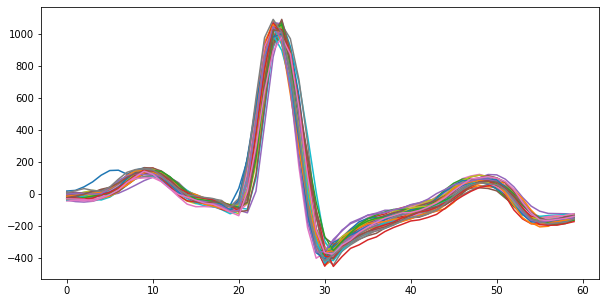

In [240]:
df = pd.read_csv("ecg_data_boneco_sr_sem_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
hb = Get_Heartbeats_3(X, picos_R, 100)
hb

613.7869571125008
(50, 60)


array([[ -41.,  -13.,   56., ..., -194., -178., -261.],
       [  32.,    1.,    7., ..., -254., -168., -211.],
       [ -26., -124.,  -39., ..., -287., -233., -233.],
       ...,
       [  31.,  -17.,   13., ..., -286., -191., -253.],
       [-113., -123.,   -2., ..., -290., -202., -234.],
       [ -19.,  -60.,  -22., ..., -208., -280., -220.]], dtype=float32)

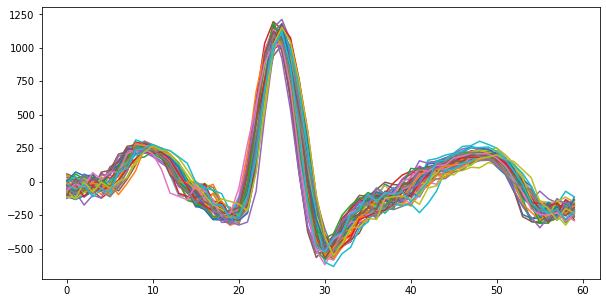

In [241]:
df = pd.read_csv("ecg_data_boneco_sr_com_ruido.csv")
X = df['values'].values.astype('float32')
picos_R = R_peak_detection(X)
hb = Get_Heartbeats_3(X, picos_R, 100)
hb

489.5780809750455
(150, 60)


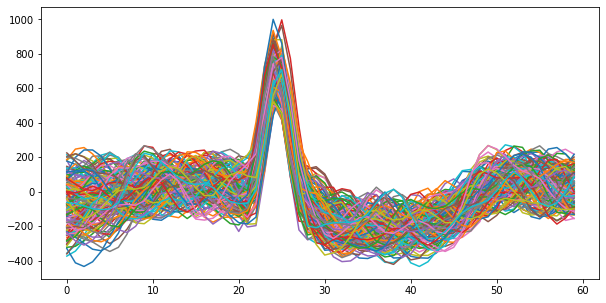

In [242]:
df = pd.read_csv("ecg_data_boneco_afib_sem_ruido.csv")
X = df['values'].values.astype('float32')
X = X
picos_R = R_peak_detection(X)
X_afib = Get_Heartbeats_3(X, picos_R, 100)

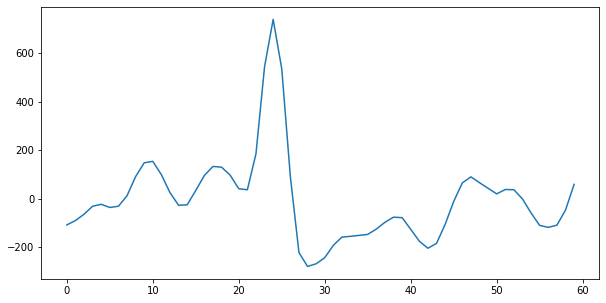

In [243]:
plt.plot(X_afib[4])

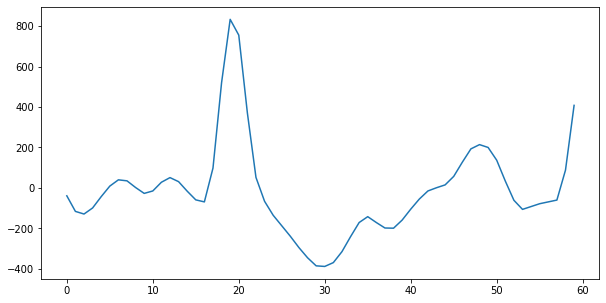

In [202]:
plt.plot(X[78:138])

In [119]:
picos_R

[27,
 98,
 139,
 179,
 219,
 279,
 349,
 388,
 449,
 494,
 566,
 638,
 708,
 749,
 823,
 896,
 969]

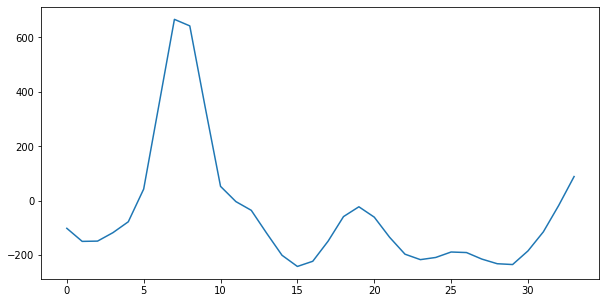

In [131]:
plt.plot(X[700:734])